# Loading graph

In [ ]:
import osmnx as ox
import networkx as nx
import os
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import alphashape

file_name = "graph.ml"
location = "Mazowieckie, Poland"

if not os.path.exists(file_name):
    print("Downloading graph")
    G = ox.graph_from_place(location, network_type='drive')
    G = ox.routing.add_edge_speeds(G, fallback=30)
    G = ox.routing.add_edge_travel_times(G) # adds travel time (seconds) to each edge
    ox.io.save_graphml(G, file_name)
else:
    print("Loading graph")
    G = ox.io.load_graphml(file_name)

print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Loading graph
Number of nodes: 136187
Number of edges: 330035


# Heuristic functions

In [2]:
def heur(n1, n2):
    n1x = G.nodes[n1]['x']
    n1y = G.nodes[n1]['y']
    n2x = G.nodes[n2]['x']
    n2y = G.nodes[n2]['y']
    return ox.distance.great_circle(n1x, n1y, n2x, n2y)

def heur_travel_time(n1, n2):
    n1x = G.nodes[n1]['x']
    n1y = G.nodes[n1]['y']
    n2x = G.nodes[n2]['x']
    n2y = G.nodes[n2]['y']
    # multiplied by Magic number - time needed to travel 1 meter at 100km/h
    return ox.distance.great_circle(n1x, n1y, n2x, n2y)*0.036

# Path

Find path

In [3]:
source_lat, source_lon = 52.275284,20.938292
# dest_lat, dest_lon = 52.1204480,21.2464419
dest_lat, dest_lon = 51.39465, 21.20062

# source_lat, source_lon = 52.169616, 21.202680
# dest_lat, dest_lon = 52.136302, 21.017951

# fetch the nearest node w.r.t coordinates
orig = ox.distance.nearest_nodes(G, source_lon, source_lat)
dest = ox.distance.nearest_nodes(G, dest_lon, dest_lat)

# find shortest path
before = time.perf_counter()
route_nodes = nx.astar_path(G, orig, dest, weight="length", heuristic=heur)
after = time.perf_counter()
print(f"Time taken: {after - before} seconds - A*, length")

# before = time.perf_counter()
# route_nodes2 = nx.dijkstra_path(G, orig, dest, weight="length")
# after = time.perf_counter()
# print(f"Time taken: {after - before} seconds - Dijkstra")

# find quickest path
before = time.perf_counter()
route_nodes3 = nx.astar_path(G, orig, dest, weight="travel_time", heuristic=heur_travel_time)
after = time.perf_counter()
print(f"Time taken: {after - before} seconds - A*, travel_time")


Time taken: 0.8735734999645501 seconds - A*, length
Time taken: 0.5797826000489295 seconds - A*, travel_time


Plot routes: blue - shortest; red - quickest

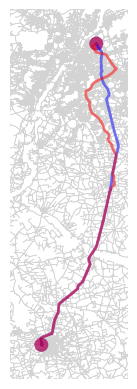

In [10]:
margin_ns = 0.1
margin_ew = 0.15
north = max(source_lat, dest_lat)+margin_ns
south = min(source_lat, dest_lat)-margin_ns
east = max(source_lon, dest_lon)+margin_ew
west = min(source_lon, dest_lon)-margin_ew

fig, ax1 = plt.subplots()

# Plot the full graph `G` as the background on the first subplot
ox.plot_graph(G, ax=ax1, node_size=0, edge_color="lightgray", edge_linewidth=0.5, show=False, close=False)
# Overlay the shortest path route on the first subplot
ox.plot_graph_route(G, route_nodes, ax=ax1, route_color="blue", route_linewidth=2, node_size=0, show=False, close=False)
# Overlay the quickest path route on the second subplot
ox.plot_graph_route(G, route_nodes3, ax=ax1, route_color="red", route_linewidth=2, node_size=0, show=False, close=False)

ax1.set_xlim(east, west)
ax1.set_ylim(south, north)

plt.show()

# Range

find range

In [5]:
s_lat, s_lon = 52.275284,20.938292
cutoff = 5*60

source = ox.distance.nearest_nodes(G, source_lon, source_lat)

reachable_nodes = nx.single_source_dijkstra_path_length(G, source, weight="travel_time", cutoff=cutoff)
reachable_subgraph = G.subgraph(reachable_nodes.keys())

Ploting range

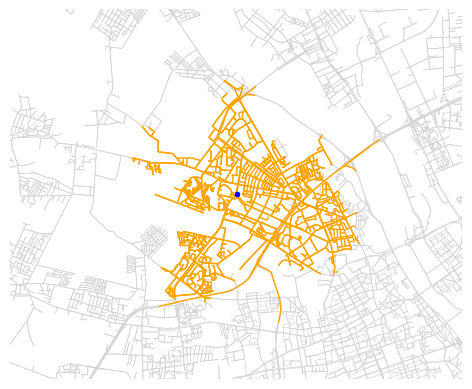

In [6]:
# Find range
reachable_nodes = nx.single_source_dijkstra_path_length(G, orig, weight="travel_time", cutoff=5*60)
reachable_subgraph = G.subgraph(reachable_nodes.keys())

# plot the reachable subgraph
fig, ax = plt.subplots()

# Draw full graph in the background
ox.plot_graph(G, ax=ax, show=False, close=False, edge_color="lightgray", bgcolor="white", node_size=0, edge_linewidth=0.5)

# Overlay the reachable subgraph
ox.plot_graph(reachable_subgraph, ax=ax, show=False, close=False, edge_color="orange", node_size=0, edge_linewidth=1)

# Highlight the start node
start_node_x, start_node_y = G.nodes[orig]["x"], G.nodes[orig]["y"]
ax.plot(start_node_x, start_node_y, color="blue", marker="o", markersize=3)

ax.set_xlim((source_lon-0.1, source_lon+0.1))
ax.set_ylim((source_lat-0.05, source_lat+0.05)) # random values but looks good with 5min cutoff :)
plt.show()

Buffer from the starting point within given time limit

In [ ]:
fig, ax = plt.subplots()
points = []
for node in reachable_subgraph.nodes():
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    points.append((x, y))

# As we increase the alpha parameter value, the bounding shape 
# will begin to fit the sample data with a more tightly fitting bounding box
alpha_shape = alphashape.alphashape(points, alpha=300) 

gpd.GeoSeries([alpha_shape], crs="EPSG:4326").plot(ax=ax, color="yellow", alpha=0.2)

plt.show()
